In [33]:
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [34]:
pd.read_csv('./data/meses/tempsolocm40cm.23025122.dia_id.mes_1.esparso.csv').head()

,Day_Station_ID,Global_Time,tempsolocm40cm,month,H0,H1,H2,H3,H4,H5,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
0,31,0,25.24,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,900,25.25,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,31,1800,25.25,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31,2700,25.28,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,31,3600,25.28,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Funções de fitness das operações

In [35]:
# Funções de Fitness
def calc_smaller(a: float, b: float):
	return b - a
def calc_greater(a: float, b: float):
	return a - b
def calc_smaller_or_equal(a: float, b: float):
	return b - a + 1
def calc_greater_or_equal(a: float, b: float):
	return a - b + 1
def calc_equal(a: float, b: float):
	return -abs(a - b)
def calc_and(a: float, b: float):
	return min(a, b)
def calc_or(a: float, b: float):
	return max(a, b)
def calc_not(a: float):
	return -a

Função que roda o programa em java

In [36]:
def run_stl(stl_input, grammar='grammar_idr.bnf', seed=1337, tournament_size=5, n_iterations=50):
  stl_cmd = 'java -Dfile.encoding=UTF-8 -classpath "./target\\classes;.\\libs\\JGEA.jar;.\\libs\\moonlight.jar;.\\libs\\jblas-1.2.4.jar" it.units.malelab.learningstl.Main seed={} grammar=grammars/{} local_search=false input={} tournament_size={} number_iterations={}'.format(seed, grammar, stl_input, tournament_size, n_iterations)
  os.system(stl_cmd)

In [37]:
def plot(vals, detected_anomalies=[], continuous_anomalies=[], margins=None, title='', save=False, img_name=None, show=True, sec_plots=[]):
	fig, ax = plt.subplots(figsize=(20, 4))
	ax.set_title(title)
	sns.lineplot(data=vals)
	for subplot in sec_plots:
		sns.lineplot(data=subplot)
	for i in detected_anomalies:
		plt.scatter(i, vals[i], s=800, marker="x", color="r", alpha=0.6)
	anom_dev = (max(vals) - min(vals))
	for i in continuous_anomalies:
		anom_top_margins = []
		anom_bottom_margins = []
		for point in range(i[0], i[1]):
			anom_top_margins.append(vals[point]+anom_dev)
			anom_bottom_margins.append(vals[point]-anom_dev)
		plt.fill_between(range(i[0], i[1]), anom_top_margins, anom_bottom_margins, alpha = 0.7, color="r", interpolate=True)
	j = 0
	if margins:
		plt.fill_between(range(len(margins[0])), margins[0], margins[1], alpha = 0.1, color="b")
	fig.tight_layout()
	if save:
		fig.savefig(img_name if img_name is not None else title, bbox_inches='tight')
	if show:	
 		plt.show()
	else:
		plt.close(fig)
	

In [38]:
def unnormalize(val, min_val, max_val):
	return (val * (max_val - min_val)) + min_val
def unnormalize_string(min_temp, max_temp, min_data, max_data):
	def f(match_group):
		if match_group[1] == 'tempsolocm40cm':
			min_val = min_temp
			max_val = max_temp
		elif match_group[1] == 'month':
			min_val = min_data
			max_val = max_data
		elif match_group[1] == 'hour':
			min_val = 0
			max_val = 23
		elif match_group[1][0] == 'H':
			min_val = 0
			max_val = 1
		return '{} {} {}'.format(match_group[1], match_group[2], unnormalize(float(match_group[3]), min_val, max_val))
	return f

Testando mês 1

In [39]:
station_id = '23025122'
meses = range(1,13)

Função que parseia e avalia uma regra

In [40]:
def parse_rule(rule: str):
	regex_search = re.search(r'AND|NOT', rule)
	if not regex_search:
		# É operador simples
		var, comp, val = re.search(r'([a-zA-Z0-9]*) ([<>=]*) ([0-9\.]*)', rule).groups()
		val = float(val)
		def comp_func(line):
			if comp == '>':
				# if not line[var] > val:
				# 	print('{} ({}) é <= {}'.format(var, line[var], val))
				return calc_greater(line[var], val)
			elif comp == '<':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_smaller(line[var], val)
			elif comp == '<=':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_smaller_or_equal(line[var], val)
			elif comp == '>=':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_greater_or_equal(line[var], val)
			else:
				# if not line[var] == val:
				# 	print('{} ({}) é != {}'.format(var, line[var], val))
				return calc_equal(line[var], val)
		return comp_func
	sub_rule = rule[regex_search.span()[1]+1:-1]
	if regex_search[0] == 'AND':
		count = 0
		sub_rule_1 = 'nada'
		sub_rule_2 = 'nada'
		for i, l in enumerate(sub_rule):
			if l == '[':
				count+=1
			if l == ']':
				count-=1
			if l == ';' and count == 0:
				sub_rule_1 = sub_rule[:i]
				sub_rule_2 = sub_rule[i+1:]
				sub_rule_func_1 = parse_rule(sub_rule_1)
				sub_rule_func_2 = parse_rule(sub_rule_2)
				def and_function(line):
					res_func_1 = sub_rule_func_1(line)
					res_func_2 = sub_rule_func_2(line)
					# if not (res_func_1 and res_func_2):
					# 	print('{} é falso porque'.format(sub_rule))
					# if not res_func_1:
					# 	print('{} é falso'.format(sub_rule_1))
					# if not res_func_2:
					# 	print('{} é falso'.format(sub_rule_2))
					return calc_and(res_func_1, res_func_2)
				return and_function
	if regex_search[0] == 'NOT':
		sub_rule_func = parse_rule(sub_rule)
		def not_funcion(line):
			res_func = sub_rule_func(line)
			# if res_func:
			# 	print('{} é verdadeiro'.format(sub_rule))
			return -res_func
		return not_funcion

In [41]:
# Função que cria as ranges
def sep_anomalies(anomalies):
	anom_start = -1
	continuous_anomalies = []
	for i, anomaly in enumerate(anomalies):
		# Se o próximo for anomalia
		if i < (len(anomalies) - 1) and anomalies[i+1] == anomaly+1:
			# E o anterior não for ou for o primeiro da lista
			if anomalies[i-1] != anomaly-1 or i == 0:
				# É começo de uma contínua
				anom_start = anomaly
		# Se o anterior é anomalia e o próximo não for ou for o fim da lista, é fim de contínuo
		elif i > 0 and anomalies[i-1] == anomaly-1:
			continuous_anomalies.append((anom_start, anomaly))
			anom_start = -1
		# Se o próximo e o anterior não forem anomalia, é isolado
		else:
			continuous_anomalies.append((anomaly, anomaly))
	return continuous_anomalies

In [42]:
# # mês 1 discreto
# mes1 = pd.read_csv('./data/meses/tempsolocm40cm.23025122.dia_id.mes_1.csv')
# regra_mes1 = 'AND[AND[AND[hour > 0.0;tempsolocm40cm > 18.128880000000002];AND[tempsolocm40cm > 24.61536;tempsolocm40cm < 26.58348]];NOT[AND[hour > 0.0;hour < 22.977]]]'
# # mês 2 esparso 
# mes2 = pd.read_csv('./data/meses/tempsolocm40cm.23025122.dia_id.mes_2.esparso.csv')
# regra_mes2 = 'AND[AND[AND[H2 == 0.0;tempsolocm40cm > 19.4298];H2 == 0.0];NOT[AND[H4 == 0.0;H6 == 0.0]]]'

In [43]:
# parser_mes1 = parse_rule(regra_mes1)
# parser_mes2 = parse_rule(regra_mes2)

In [44]:
# sum_rob = 0
# for i, r in mes1.iterrows():
# 	rob = parser_mes1(r)
# 	sum_rob += rob
# 	if rob >= 0:
# 		print(i)
# print(sum_rob)

Gerando regras e limpando saída

In [45]:
img_name = 'tempsolocm40cm.{}.dia_id.mes_1_estou_louco'.format(station_id, mes)
series_name = 'tempsolocm40cm.{}.dia_id.mes_1_estou_louco.csv'.format(station_id, mes)
grammar = 'grammar_idr_estou_louco.bnf'
series_file = './data/meses/{}'.format(series_name)
output_file = './output/{}'.format(series_name)
run_stl(series_file, seed=54321, n_iterations=500, tournament_size=15, grammar=grammar)
series = pd.read_csv(series_file)

with open(output_file, 'r') as f:
	lines = f.readlines()
with open(output_file, 'w') as f:
	for i, line in enumerate(lines):
		if i == 0 or not line.startswith('iterations,births,fitness.evaluations'):
				f.write(line)

output = pd.read_csv(output_file)

output['serialized'] = [re.sub(r'([a-zA-Z0-9]*) ([<>=]*) ([0-9\.]*)', unnormalize_string(min(series['tempsolocm40cm']), max(series['tempsolocm40cm']), min(series['month']), min(series['month'])), rule) for rule in output['serialized']]
output.to_csv('./output/{}'.format(series_name), index=0)

# regras = output['serialized'].to_list()
# avaliacoes = output['best.fitness.value'].to_list()
# # Tirando regras que não usam a temperatura
# # regras = [regra for regra in regras if regra.find('tempsolocm40cm') >= 0]
# # eval_regras = []
# for regra, score in zip(regras, avaliacoes):
# 	function = parse_rule(regra)
# 	id_linhas = []
# 	for i, serie in series.iterrows():
# 		if score < 0:
# 			id_linhas.append(i)
	
# 	if regra.find('tempsolocm40cm') >= 0:
# 		cont = sep_anomalies(id_linhas)
# 		plot(series['tempsolocm40cm'], continuous_anomalies=cont, title='{}, {}'.format(regra, score), save=True, show=False, img_name='./output/{}_{}_{}.jpg'.format(img_name, regra, score))

In [46]:
img_name = 'tempsolocm40cm.{}.dia_id.mes_1_estou_louco'.format(station_id, mes)
series_name = 'tempsolocm40cm.{}.dia_id.mes_1_estou_louco.csv'.format(station_id, mes)
grammar = 'grammar_idr_estou_louco.bnf'
series_file = './data/meses/{}'.format(series_name)
output_file = './output/{}'.format(series_name)
best_regras = pd.read_csv(output_file)
series = pd.read_csv(series_file)

# Tirando regras que não usam a temperatura
# regras = [regra for regra in regras if regra.find('tempsolocm40cm') >= 0]
# eval_regras = []
regra = best_regras.iloc[-1]
function = parse_rule(regra['serialized'])
id_linhas = []
for i, serie in series.iterrows():
	if function(serie) < 0:
		id_linhas.append(i)
cont = sep_anomalies(id_linhas)
plot(series['tempsolocm40cm'], continuous_anomalies=cont, title='{}, {}'.format(regra['serialized'], regra['best.fitness.value']), save=True, show=False, img_name='./output/imagens/{}_{}.jpg'.format(img_name, regra['best.fitness.value']))

In [14]:
for mes in meses:
	for esparso in [False, True]:
		if esparso:
			img_name = 'tempsolocm40cm.{}.dia_id.mes_{}.esparso'.format(station_id, mes)
			series_name = 'tempsolocm40cm.{}.dia_id.mes_{}.esparso.csv'.format(station_id, mes)
			grammar = 'grammar_idr_esparso.bnf'
			series_file = './data/meses/{}'.format(series_name)
			output_file = './output/{}'.format(series_name)
		else:
			img_name = 'tempsolocm40cm.{}.dia_id.mes_{}'.format(station_id, mes)
			series_name = 'tempsolocm40cm.{}.dia_id.mes_{}.csv'.format(station_id, mes)
			grammar = 'grammar_idr.bnf'
			series_file = './data/meses/{}'.format(series_name)
			output_file = './output/{}'.format(series_name)
		best_regras = pd.read_csv(output_file)
		series = pd.read_csv(series_file)
	
		# Tirando regras que não usam a temperatura
		# regras = [regra for regra in regras if regra.find('tempsolocm40cm') >= 0]
		# eval_regras = []
		regra = best_regras.iloc[-1]
		function = parse_rule(regra['serialized'])
		id_linhas = []
		for i, serie in series.iterrows():
			if function(serie) < 0:
				id_linhas.append(i)
		cont = sep_anomalies(id_linhas)
		plot(series['tempsolocm40cm'], continuous_anomalies=cont, title='{}, {}'.format(regra['serialized'], regra['best.fitness.value']), save=True, show=False, img_name='./output/imagens/{}_{}.jpg'.format(img_name, regra['best.fitness.value']))

In [47]:
pd.read_csv('./data/meses/tempsolocm40cm.23025122.dia_id.mes_1.csv').head()

,Day_Station_ID,Global_Time,tempsolocm40cm,month,hour
0,31,0,25.24,1,0
1,31,900,25.25,1,0
2,31,1800,25.25,1,0
3,31,2700,25.28,1,0
4,31,3600,25.28,1,1


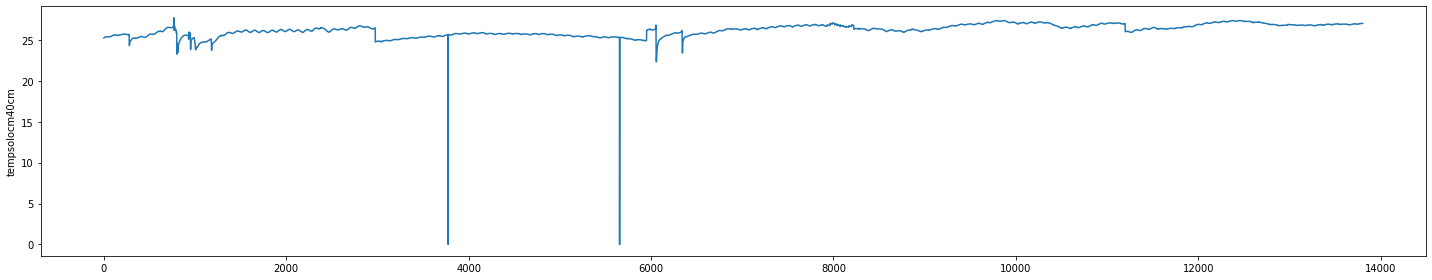

In [19]:
plot(pd.read_csv('./data/meses/tempsolocm40cm.23025122.dia_id.mes_1.csv')['tempsolocm40cm'], save=True, img_name='img.jpg')